<!-- SOLUTION CELL -->
<h2 style="color: red">This is the solutions file!</h2>

<span style="color: red">We strongly recommend not looking at this file, which contains the solutions to all the exercises, until after the practical is over. Use [`testing.ipynb`](testing.ipynb) instead.</span>

$
\DeclareMathOperator{\E}{\mathbb E}
\DeclareMathOperator{\Var}{Var}
\DeclareMathOperator{\Tr}{Tr}
\DeclareMathOperator{\MMD}{MMD}
\DeclareMathOperator{\MMDhat}{\widehat{MMD}}
\newcommand{\PP}{\mathbb{P}}
\newcommand{\QQ}{\mathbb{Q}}
\newcommand{\h}{\mathcal H}
$This is the second part of the practical components of the tutorial, on two-sample testing.

It doesn't overlap too much with [the ridge regression section](ridge.ipynb), but we're going to assume you've done (at least the first parts of) that one first.

This section is an updated version of (most of) [Heiko Strathmann](http://herrstrathmann.de/)'s [materials](https://github.com/karlnapf/ds3_kernel_testing) for a DS3 2018 tutorial.

Again, we'll use PyTorch; you might want a GPU for some optional bits at the end, but CPU on a laptop should be fine until then.

In [1]:
import os
try:
    import google.colab
except ImportError:
    pass
else:
    if not os.path.exists('data/blobs.npz'):
        !git clone https://github.com/djsutherland/ds3-kernels
        os.chdir('ds3-kernels')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook')
from IPython.display import display, Markdown, HTML

from tqdm.notebook import tqdm
# from tqdm import tqdm  # if you're in JupyterLab/etc and this doesn't work well

import functools

import numpy as np
import sklearn
from sklearn import model_selection
import torch

import ds3_support
from ds3_support import as_tensors, LazyKernel, pil_grid

## A note

Please ask me for help if you get stuck! Whether it's with a PyTorch thing, some other code thing, or especially something conceptual – that's what I'm here for. Solutions are also available in [`solutions-testing.ipynb`](solutions-testing.ipynb), but you're better off not rushing straight to those; I'm happy to help you try to help you work things out yourself, which is probably better for you. :)

## Starting out with two-sample testing

In [2]:
# SOLUTION CELL
# Generate the data...mean-shifted Gaussians
N = 1000
rs = np.random.RandomState(seed=0)
X = rs.randn(N).astype(np.float32)
Y = rs.randn(N).astype(np.float32) + 0.2
np.savez('data/simple.npz', X=X, Y=Y)

(array([  3.,   2.,   1.,   7.,  16.,  31.,  37.,  44.,  78.,  70.,  91.,
         91., 119.,  91.,  87.,  68.,  47.,  43.,  29.,  21.,   9.,   7.,
          6.,   1.,   1.]),
 array([-2.794613  , -2.5479894 , -2.3013659 , -2.0547423 , -1.8081188 ,
        -1.5614953 , -1.3148718 , -1.0682484 , -0.8216248 , -0.5750013 ,
        -0.3283778 , -0.08175431,  0.16486919,  0.4114927 ,  0.6581162 ,
         0.90473974,  1.1513633 ,  1.3979868 ,  1.6446103 ,  1.8912337 ,
         2.1378572 ,  2.3844807 ,  2.6311042 ,  2.8777277 ,  3.1243513 ,
         3.3709748 ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f3f9f8a7e50>])

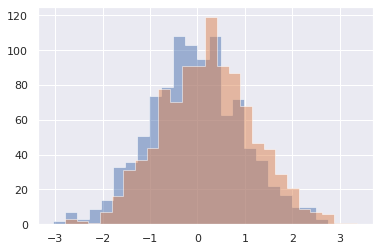

In [3]:
with np.load('data/simple.npz') as data:
    X, Y = as_tensors(data['X'], data['Y'])
    
plt.hist(X.numpy(), alpha=.5, bins='auto', histtype='stepfilled')
plt.hist(Y.numpy(), alpha=.5, bins='auto', histtype='stepfilled');

Question: do $X$ and $Y$ come from the same distribution?

## Comparing means

Let's start by comparing the means of the samples.
If the distributions are the same, their means are the same,
so the expectation of this statistic would be zero.

In [4]:
def mean_difference(X, Y, squared=False):
    X, Y = as_tensors(X, Y)
    assert len(X.shape) == len(Y.shape) == 1
    
    # TODO: compute mean difference of X and Y
    result = X.mean() - Y.mean()  # SOLUTION
    
    return (result * result) if squared else result

mean_difference(X, Y).item()

-0.2588736414909363

Well, it's not zero...but of course we were never going to get *exactly* zero.

Where do we draw the line?

The classical statistical way to do this is to assume that $P_X = P_Y$ (the null hypothesis), and consider what the distribution of the test statistic would be in that case (the null distribution). If the number we observe would be very unlikely under the null distribution, then we "reject the null" and say that the two samples are different.

One way to do this is called _permutation testing_. This is based on the observation that if $P_X = P_Y$, then we can shuffle the samples together, and that won't change the distribution of our shuffled $X'$ or $Y'$ (under the null). We can then compute what our test statistic would be if we did this a bunch of times, and this will give us an estimate of what the true null distribution is. If we do a lot of permutation samples, and our test statistic landed above, say, 99% of them, then we can reject the null hypothesis.

In [5]:
def two_sample_permutation_test(
    test_statistic, X, Y, num_permutations=1000, progress=True
):
    X, Y = as_tensors(X, Y)
    assert len(X.shape) == len(Y.shape)
    
    orig_stat = test_statistic(X, Y)
    
    range_ = range(num_permutations)
    if progress:
        range_ = tqdm(range_)
    
    # concatenate samples together
    Z = torch.cat([X, Y], 0)
    
    stats = []
    n_X = X.shape[0]                                  # SOLUTION
    for i in range_:
        # TODO: permute samples and compute test statistic
        np.random.shuffle(Z.numpy())                  # SOLUTION
        this_stat = test_statistic(Z[:n_X], Z[n_X:])  # SOLUTION
        stats.append(this_stat)
    return orig_stat, torch.stack(stats)

In [6]:
def plot_permutation_samples(statistic, null_samples, ax=None,
                             from_zero=False, one_sided=False, alpha=1,
                             level=.05):    
    null_samples = np.asarray(null_samples)
    if ax is None:
        ax = plt.gca()
    
    ax.hist(null_samples, bins='auto', histtype='stepfilled',
            label="Permutation samples", alpha=alpha)
    
    if from_zero:
        lo = 0
        hi = np.percentile(null_samples, 100 * (1 - level))
    elif one_sided:
        lo = np.min(null_samples)
        # should be -inf, but that takes more code
        hi = np.percentile(null_samples, 100 * (1 - level))
    else:
        lo = np.percentile(null_samples, 100 * level / 2)
        hi = np.percentile(null_samples, 100 * (1 - level / 2))
    
    ax.axvspan(lo, hi, fc='b', alpha=.25, label="95% region")
    
    ax.axvline(x=statistic, c='r', lw=2, label="Actual statistic")
    ax.legend(loc='best')
    
    ax.set_xlabel("Test statistic value")
    ax.set_ylabel("Counts")
    
    if from_zero:
        ax.set_xlim(0, ax.get_xlim()[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

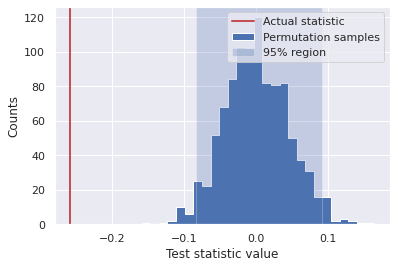

In [7]:
plot_permutation_samples(
    *two_sample_permutation_test(mean_difference, X, Y))

Depending on the test statistic, there might be many other ways to compute the null distribution.
Not all of them work via sampling it directly like this – which can be pretty expensive, e.g. 500 times as expensive as the test in the first place....

For example, for our mean difference test statistic, if we assume that $X$ and $Y$ are each Gaussian, the distribution of the statistic is also Gaussian – as we can see, at least roughly, in this plot. 
We might be even able to analytically work out the parameters of this distribution.

If you haven't realized, this is basically a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), where we assume that we know that both distributions have the same variance so we can distinguish them via solely looking at their mean. (In this particular case, that's true....)

As it will be useful for kernel based test statistics later, we will also look at the distribution of a squared test statistic, in order to make it strictly positive, but still tend to zero if the two distributions are the same.
Naturally, the average of squared Gaussian random variables has a chi-square distribution -- something that can be used for the kernel tests that we introduce later.

  0%|          | 0/1000 [00:00<?, ?it/s]

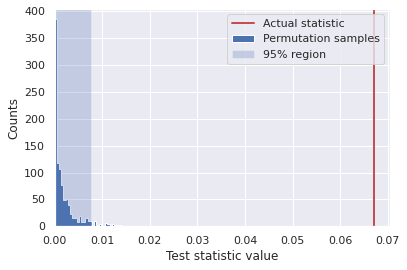

In [8]:
squared_mean_diff = functools.partial(mean_difference, squared=True)

plot_permutation_samples(
    *two_sample_permutation_test(squared_mean_diff, X, Y),
    from_zero=True)

### Alternative distribution via explicit simulation

The test statistic also has a distribution under the alternative hypothesis ($P_X \neq P_Y$); our computed test statistic is only a single sample from this distribution.

Unfortunately, it's not easy to look at this alternative distribution in practice,
unless we have a way to generate more data.
But let's take a look in a synthetic case where we know the true distribution.

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

(array([29., 34., 56., 52., 77., 61., 55., 42., 30., 19., 11.,  9., 12.,
         4.,  2.,  1.,  2.,  3.,  1.]),
 array([0.00186037, 0.02020502, 0.03854968, 0.05689433, 0.07523899,
        0.09358365, 0.1119283 , 0.13027296, 0.14861761, 0.16696227,
        0.18530692, 0.20365158, 0.22199623, 0.24034089, 0.25868554,
        0.2770302 , 0.29537486, 0.31371951, 0.33206417, 0.35040882]),
 [<matplotlib.patches.Polygon at 0x7f3f9ee556d0>])

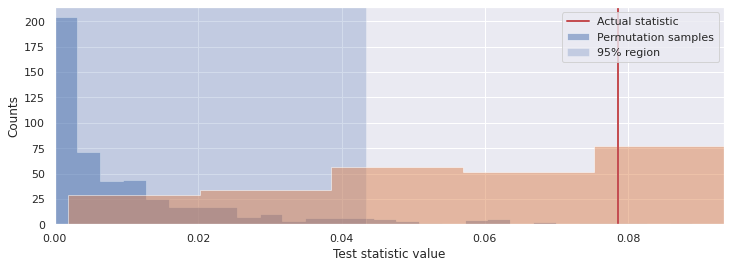

In [9]:
np.random.seed(3); torch.manual_seed(0)

# This is a case when the null hypothesis is false:
N = 200
sample_X = lambda: torch.randn(N)
sample_Y = lambda: torch.randn(N) + 0.3

# Do the normal testing thing, where we have one sample from each.
X = sample_X()
Y = sample_Y()

# single sample from the alternative + null estimates
stat, perm_samples = two_sample_permutation_test(squared_mean_diff, X, Y, num_permutations=500)

statistics_alt = np.zeros(500)
# TODO: fill statistics_alt with samples from the alternative distribution
for i in tqdm(range(statistics_alt.shape[0])):                     # SOLUTION
    statistics_alt[i] = squared_mean_diff(sample_X(), sample_Y())  # SOLUTION

fig, ax = plt.subplots(figsize=(12, 4))
plot_permutation_samples(stat, perm_samples, ax=ax, from_zero=True, alpha=.5)
ax.hist(statistics_alt, alpha=0.5, bins='auto',
        label='Alternative samples', histtype='stepfilled');


As you can see, even though most of the alternative distribution far larger than the null, we can be unlucky: there are a significant portion of datasets for which the test would not reject the null simply by chance -- we only have a single draw from the alternative.
With this fixed seed, we got lucky, but a decent portion of the time we wouldn't reject the null, even though it's not true.

**Optional:** Play with the sample size, or the amount of difference between $X$ and $Y$, and see how this impacts the position of the alternative distribution (and as such the test power).

**Optional:** Actually generate more data from the null distribution, also. How well does the permutation distribution approximate the true null? How does this change with smaller / larger `N`?

### Another dataset

In [10]:
# SOLUTION CELL
# gaussian vs laplace with same mean / variance
from scipy import stats

np.random.seed(2)
N = 300
X = stats.norm.rvs(size=N).astype(np.float32)
Y = stats.laplace.rvs(size=N, scale=np.sqrt(.5)).astype(np.float32)

np.savez('data/almost_simple.npz', X=X, Y=Y)

(array([ 2.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,  7.,  6., 13., 14., 27.,
        38., 48., 48., 26., 18., 13.,  7.,  7.,  5.,  6.,  1.,  2.,  0.,
         3.,  1.,  0.,  0.,  0.,  2.]),
 array([-3.5426064 , -3.3034866 , -3.064367  , -2.8252473 , -2.5861278 ,
        -2.347008  , -2.1078885 , -1.8687687 , -1.629649  , -1.3905294 ,
        -1.1514097 , -0.91229004, -0.6731704 , -0.43405074, -0.19493106,
         0.0441886 ,  0.28330827,  0.5224279 ,  0.76154757,  1.0006672 ,
         1.2397869 ,  1.4789066 ,  1.7180263 ,  1.9571459 ,  2.1962657 ,
         2.4353852 ,  2.674505  ,  2.9136245 ,  3.1527443 ,  3.3918638 ,
         3.6309836 ,  3.8701031 ,  4.109223  ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f3f9ee297c0>])

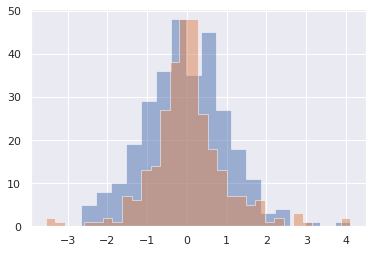

In [11]:
with np.load('data/almost_simple.npz') as d:
    X, Y = as_tensors(d['X'], d['Y'])

plt.hist(X.numpy(), alpha=.5, bins='auto', histtype='stepfilled')
plt.hist(Y.numpy(), alpha=.5, bins='auto', histtype='stepfilled');

Looks like the mean won't cut it this time. Maybe the standard deviation?

**Exercise:** Implement a two-sample test statistic based on both the mean and the standard deviation, e.g. $(\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2$.

  0%|          | 0/1000 [00:00<?, ?it/s]

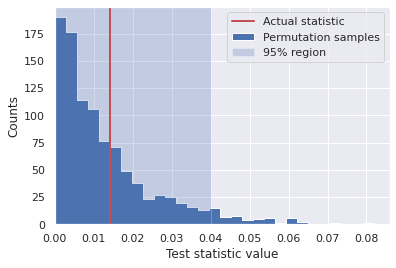

In [12]:
def mean_std_stat(X, Y):
    X, Y = as_tensors(X, Y)
    assert len(X.shape) == len(Y.shape) == 1
    # TODO: implement
    
    return (X.mean() - Y.mean()) ** 2 + (X.std() - Y.std()) ** 2

plot_permutation_samples(
    *two_sample_permutation_test(mean_std_stat, X, Y),
    from_zero=True)

No good. Of course, it's possible we were just unlucky (as we saw could happen above), but this test clearly can't distinguish between distributions with the same mean and variance in any case – so it's time to move onto something better.

## Maximum Mean Discrepancy

As we saw in the lectures this morning, the MMD can be thought of as either
$$
\MMD(\PP, \QQ)
= \sup_{f \in \mathcal H : \lVert f \rVert_{\mathcal H} \le 1} \E_{X \sim \PP}[f(X)] - \E_{Y \sim \QQ}[ f(Y) ]
$$
or, more relevantly right now,
$$
\MMD(\PP, \QQ)
=
\lVert
\E_X[ \varphi(X) ]
- \E_Y[ \varphi(Y) ]
\rVert_{\mathcal H}
$$
where $\varphi : \mathcal X \to \mathcal H$ is the feature map.

If we take $\varphi(x) = x$, corresponding to a linear kernel, then our squared difference in means is exactly the squared MMD. But we can do a lot better by picking a different kernel.

In [13]:
class LinearKernel(LazyKernel):
    def _compute(self, A, B):
        return A @ B.t()

**Exercise:** does the difference in means + standard deviations that we used above correspond to an MMD with some kernel? If so, what kernel? If not, is there a kernel MMD that can distinguish the same set of distributions as that can?

Remember from lecture that a *characteristic* kernel, like the Gaussian, can distinguish *any* pair of distributions (with enough samples). Let's start with the Gaussian; go ahead and bring over your implementation from the other notebook.

In [14]:
class RBFKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
        self.const_diagonal = 1  # Says that k(x, x) = 1 for any x
    
    # TODO: implement _compute (maybe with _precompute)
    def _precompute(self, A):                                            # SOLUTION
        # Squared norms of each data point                               # SOLUTION
        return [torch.einsum("ij,ij->i", A, A)]                          # SOLUTION
                                                                         # SOLUTION
    def _compute(self, A, A_sqnorms, B, B_sqnorms):                      # SOLUTION
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())   # SOLUTION
        return torch.exp(D2 / (-2 * self.sigma ** 2))                    # SOLUTION


### `Matrix` classes

There's also one handy thing about these `LazyKernel` classes that we didn't need in the ridge regression setting, but might be useful here. (You don't have to use them, but you can.)

if you do `K.XY_m` (or `K.YY_m` or `K.matrix(0, 1)`, etc), then you get a special `ds3_support.kernels.Matrix` subclass. This implements – and caches – various operations you might need. Let's take a look:

In [15]:
# make X, Y into [n, 1] matrices instead of just vectors
if len(X.shape) == 1:
    X = X[:, None]
if len(Y.shape) == 1:
    Y = Y[:, None]

In [16]:
K = RBFKernel(X, Y)

In [17]:
K.XY_m

<SquareMatrix, 300 by 300>

In [18]:
K.XX_m

<SymmetricConstDiagMatrix, 300 by 300>

In [19]:
print('  '.join(m for m in dir(K.XY_m) if not m.startswith('_')))

col_sums  col_sums_sq_sum  diagonal  m  mat  mean  n  offdiag_col_sums  offdiag_col_sums_sq_sum  offdiag_mean  offdiag_row_sums  offdiag_row_sums_sq_sum  offdiag_sq_sum  offdiag_sum  row_sums  row_sums_sq_sum  shape  sq_sum  sq_trace  sum  trace


In [20]:
print('  '.join(m for m in dir(K.XX_m) if not m.startswith('_')))

col_sums  col_sums_sq_sum  diag_value  diagonal  m  mat  mean  n  offdiag_col_sums  offdiag_col_sums_sq_sum  offdiag_mean  offdiag_row_sums  offdiag_row_sums_sq_sum  offdiag_sq_sum  offdiag_sum  offdiag_sums  offdiag_sums_sq_sum  row_sums  row_sums_sq_sum  shape  sq_sum  sq_trace  sum  sums  sums_sq_sum  trace


In [21]:
K.XX_m.mean(), K.XX_m.offdiag_mean()

(tensor(0.5669), tensor(0.5655))

Check out the second half of [`ds3_support/kernels.py`](ds3_support/kernels.py) to see how they're implemented / what options there are.

### MMD estimators

Okay, enough admiring my beautiful code. Remember that we have
\begin{align}
\MMD^2(\PP, \QQ)
  &= \lVert \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ] \rVert_\h^2
\\&= \langle
        \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ],
        \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ]
     \rangle_\h
\\&= \langle \E_X[ \varphi(X) ], \E_X[ \varphi(X) \rangle_\h
   + \langle \E_Y[ \varphi(Y) ], \E_Y[ \varphi(Y) \rangle_\h
   - 2 \langle \E_X[ \varphi(X) ], \E_Y[ \varphi(Y) ] \rangle_\h
\\&= \E_{X, X', Y, Y'}\left[
     \langle \varphi(X), \varphi(X') \rangle_\h
   + \langle \varphi(Y), \varphi(Y') \rangle_\h
   - 2 \langle \varphi(X), \varphi(Y) \rangle_\h
   \right]
\\&= \E_{X, X', Y, Y'}\left[
     k(X, X')
   + k(Y, Y')
   - 2 k(X, Y)
   \right]
.\end{align}

This gives a pretty natural idea for how to estimate the MMD. Well, three ideas of varying amounts of naturalness:

The *biased* estimator (exactly the MMD between the empirical distributions) is, if we have $m$ samples from $X$ and $n$ from $Y$:
$$
\MMDhat_b^2(X, Y)
= \frac{1}{m^2} \sum_{i=1}^m \sum_{j=1}^m k(X_i, X_j)
+ \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n k(Y_i, Y_j)
- \frac{2}{m n} \sum_{i=1}^m \sum_{j=1}^n k(X_i, Y_j)
.$$
But this term has an bias due to the $k(X_i, X_i)$ and $k(Y_i, Y_i)$ terms. (You can tell that it's biased because we can have $\MMD^2(\PP, \QQ) = 0$, but we can have $\MMDhat^2(X, Y) > 0$ even when $\PP = \QQ$ but we can't have $\MMDhat^2(X, Y) < 0$. Thus $\E \MMDhat^2(X, Y) > 0$.

The *unbiased* estimator gets rid of these terms:
$$
\MMDhat_u^2(X, Y)
= \frac{1}{m (m-1)} \sum_{i \ne j}^m k(X_i, X_j)
+ \frac{1}{n (n-1)} \sum_{i \ne j}^n k(Y_i, Y_j)
- \frac{2}{m n} \sum_{i=1}^m \sum_{j=1}^n k(X_i, Y_j)
.$$
This makes it unbiased, and in fact it's the minimum variance unbiased estimator.

The $U$-statistic estimator only works when $n = m$, and also takes out the $k(X_i, Y_i)$ terms, which gives you a slightly worse estimator:
$$
\MMDhat_U^2(X, Y)
= \frac{1}{m (m-1)} \sum_{i \ne j}^m \left(
    k(X_i, X_j) + k(Y_i, Y_j) - 2 k(X_i, Y_j)
  \right)
.$$
The advantage is that $U$-statistics have been studied pretty thoroughly by statisticians, so we know things about their variance and whatnot.

**Exercise:** Implement these estimators, as functions of a `LazyKernel(X, Y)`. Using the `Matrix` helpers, each can be literally one line, but you can implement it however you feel like. You don't necessarily have to do all three; do at least one of them, but the others aren't too much extra work on top of the first one.

In [22]:
def mmd2_biased(K):
    pass  # TODO: implement, using K.XX, K.XY, K.YY (or _m)
    return K.XX_m.mean() + K.YY_m.mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_unbiased(K):
    pass  # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_u_stat(K):
    assert K.ns[0] == K.ns[1]
    # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.offdiag_mean()  # SOLUTION

  0%|          | 0/1000 [00:00<?, ?it/s]

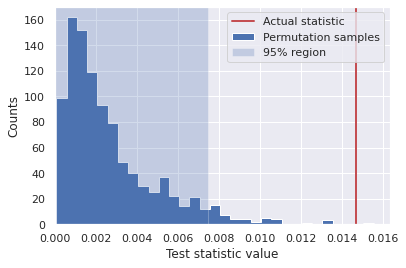

In [23]:
plot_permutation_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_biased(RBFKernel(X, Y)), X, Y),
    from_zero=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

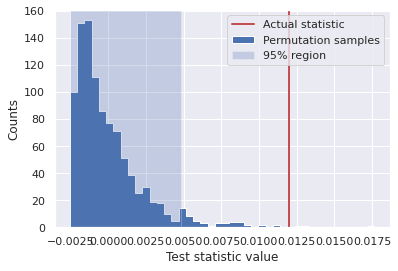

In [24]:
plot_permutation_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_unbiased(RBFKernel(X, Y)), X, Y),
    one_sided=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

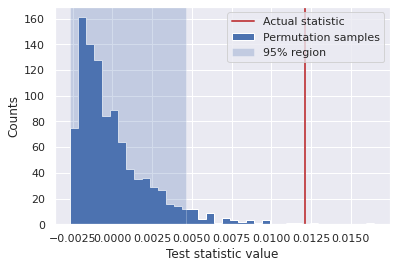

In [25]:
plot_permutation_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_u_stat(RBFKernel(X, Y)), X, Y),
    one_sided=True)

They're all pretty much the same; when you're just doing permutation testing, the differences between them aren't super important.

**Exercise:** Run the test with a `LinearKernel`. Which of our estimators, if any, corresponds to the `mean_difference` statistic from before? (Do you understand why?)

  0%|          | 0/1000 [00:00<?, ?it/s]

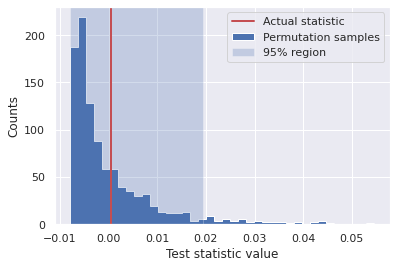

In [26]:
# SOLUTION CELL
plot_permutation_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_u_stat(LinearKernel(X, Y)), X, Y),
    one_sided=True)

In [27]:
# SOLUTION CELL
# Answer: it's mmd2_biased, as you can see e.g. by
# expanding k(x, y) = x y in the equation for the sum.
# Here's the numerical check:
K = LinearKernel(X, Y)
torch.stack([
    mean_difference(X.squeeze(1), Y.squeeze(1), squared=True),
    mmd2_biased(K),
    mmd2_unbiased(K),
    mmd2_u_stat(K),
])

tensor([6.7584e-03, 6.7584e-03, 3.7863e-06, 4.6972e-04])

**Optional:** We're working on small datasets here so far, so this implementation of permutations is fine. But notice that we're recomputing the kernel matrix for each permutation, even though the matrices actually have all the same elements (just in jumbled-up order). Implement a faster way that doesn't involve this recomputation.

Hint: this is easiest for the biased estimator, which you can write in a way amenable to [this kind of approach](https://pytorch.org/docs/stable/torch.html#torch.einsum). (The `LazyKernel.joint()` method, which concatenates all the kernel matrices together, might be useful.) Doing some algebra to work out a few slightly annoying correction terms, you can also do it similarly for the U-statistic estimator.

If you're really, really careful, you can also make the unbiased estimator really fast (exploiting cache locality and things like that). We wrote about this in [this paper](https://arxiv.org/abs/1611.04488) (Section 3), and it's implemented in [Shogun](https://www.shogun-toolbox.org/). (Example usage [here](http://shogun.ml/examples/latest/examples/statistical_testing/quadratic_time_mmd.html).)

**Extra credit:** empirically compare how our silly implementation here, your faster implementation, and the Shogun implementation scale as the dataset size increases.

In [28]:
# Override this function if you implement a better one yourself,
# and the stuff later will run faster....
# This just establishes an API for passing in a kernel directly,
# which is a little clumsy to implement, but it's not any faster.
def mmd2_permutations_slow(K, use_biased=True, num_permutations=1000, progress=True):
    # Some fiddling to be able to use the same kernel with "new" data.
    from copy import copy
    K_copy = copy(K)
    def mmd2_with_K(X, Y):
        K_copy.change_part(0, X)
        K_copy.change_part(1, Y)
        return (mmd2_biased if use_biased else mmd2_unbiased)(K_copy)
    
    return two_sample_permutation_test(
        mmd2_with_K, K.X, K.Y,
        num_permutations=num_permutations, progress=progress)

mmd2_permutations = mmd2_permutations_slow

  0%|          | 0/1000 [00:00<?, ?it/s]

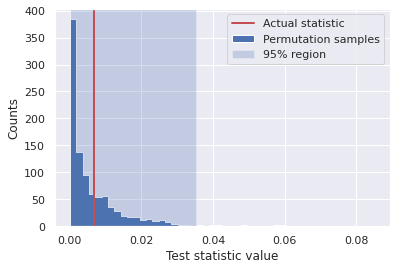

In [29]:
plot_permutation_samples(*mmd2_permutations_slow(K))

In [30]:
# SOLUTION CELL
def mmd2_permutations(K, use_biased=True, permutations=1000, progress=None):
    # progress is ignored
    full_kernel = K.joint()
    assert K.n_parts == 2
    n_X, n_Y = K.ns
    n = n_X + n_Y

    if use_biased:
        w_X = 1 / n_X
        w_Y = -1 / n_Y
    else:  # use U statistic
        assert n_X == n_Y
        w_X = 1
        w_Y = -1

    ws = torch.full((permutations + 1, n), w_Y,
                    dtype=full_kernel.dtype, device=full_kernel.device)
    ws[-1, :n_X] = w_X
    for i in range(permutations):
        ws[i, np.random.choice(n, n_X, replace=False)] = w_X

    biased_ests = torch.einsum("pi,ij,pj->p", ws, full_kernel, ws)
    if use_biased:
        ests = biased_ests
    else:
        # need to subtract \sum_i k(X_i, X_i) + k(Y_i, Y_i) + 2 k(X_i, Y_i)
        # first two are just trace, but last is harder:
        is_X = ws > 0
        X_inds = is_X.nonzero()[:, 1].view(permutations + 1, n_X)
        Y_inds = (~is_X).nonzero()[:, 1].view(permutations + 1, n_Y)
        del is_X, ws
        cross_terms = K.take(Y_inds * n + X_inds).sum(1)
        del X_inds, Y_inds
        ests = (biased_ests - K.trace() + 2 * cross_terms) / (n_X * (n_X - 1))

    est = ests[-1]
    rest = ests[:-1]
    return est, rest

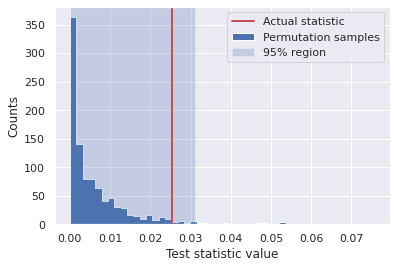

In [31]:
plot_permutation_samples(*mmd2_permutations(K))

### Alternative methods to estimate the null distribution

There are many other way to get our hands on the distribution of the MMD test statistic under the null hypothesis.

We know that asymptotically, the distribution is an infinite sum of Chi-square variables – but it's an infinite sum, and we don't even know what sum it is, so that doesn't help us too much.
Techniques to approximate it include:

* moment matching using a Gamma distribution: fast, but doesn't result in a consistent test.
* a spectral approximation: using eigenvalues of the kernel matrix, we can estimate that infinite sum. Costly (cubic!) for large sample sets.
* wild bootstrap: a technique used for correlated samples that is similar to permuting. (It's useful for e.g. testing an MCMC chain, though.)
* linear time statistics: for those, one can often show that the null distribution is Gaussian, with a variance you can estimate in closed form.

We won't cover any of these here, since they require some more details.
The permutation test, while it can potentially be slow, is easy to understand and works for most applications (if implemented well).

[This old Shogun notebook](https://nbviewer.jupyter.org/github/shogun-toolbox/shogun/blob/develop/doc/ipython-notebooks/statistical_testing/mmd_two_sample_testing.ipynb) contains many null approximation methods.

## MMD witness function in the RKHS

One nice feature of the MMD is that we can see where the density functions are different by looking at the (empirical) MMD witness function.
Remember that
\begin{align}
\MMD(\PP, \QQ)
  &= \sup_{f : \lVert f \rVert_\h \le 1} \E_{X \sim \PP} f(X) - \E_{Y \sim \QQ} f(Y)
\\&= \sup_{f : \lVert f \rVert_\h \le 1} \langle f, \E_{X \sim \PP}[\varphi(X)] - \E_{Y \sim \QQ}[\varphi(Y)] \rangle_\h
\end{align}
and so
$$
f^* \propto \E_{X \sim \PP}[\varphi(X)] - \E_{Y \sim \QQ}[\varphi(Y)]
,$$
which means (using $f^*(t) = \langle f^*, \varphi(t) \rangle_\h$)
$$
f^*(t) \propto \E_{X \sim \PP} k(X, t) - \E_{Y \sim \QQ} k(Y, t)
.$$

We can estimate $f^*$ with empirical averages.

**Thought exercises:**
- What's the proportionality constant hidden by $\propto$?
- Does the constant matter?
- Which MMD estimator, if any, does directly estimating $f^*$ correspond to?

The points where $\lvert f^*(t) \rvert$ are large are where the MMD test considers $\PP$ and $\QQ$ to be the "most different."
Let's define a grid and evaluate the witness function on it to see where that is.

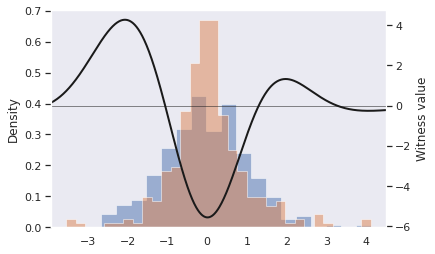

In [32]:
def mmd_witness(K, eval_pts):
    assert K.n_parts == 2
    K.append_part(eval_pts[:, None])  # now K.XZ compares X to eval_pts
    
    witness = 0
    # TODO: estimate MMD witness function on grid_pts
    witness = K.XZ.mean(0) - K.YZ.mean(0)  # SOLUTION
    
    K.drop_last_part()
    witness = witness / mmd2_biased(K)  # to normalize; not necessary  # SOLUTION
    return witness

def plot_mmd_witness_1d(K, ax=None, grid_num=1000):
    X, Y = [t.squeeze(1) for t in K.parts]
    assert len(X.shape) == 1
    
    if ax is None:
        ax = plt.gca()
    ax.hist(X.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.hist(Y.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.grid(False)
    ax.set_ylabel("Density")
    
    ax2 = ax.twinx()
    lo, hi = ax2.get_xlim()
    grid_pts = torch.linspace(lo, hi, grid_num)
    ax2.plot(grid_pts.numpy(), mmd_witness(K, grid_pts).numpy(), color='k', lw=2)
    ax2.set_xlim(lo, hi)
    ax2.grid(False)
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_ylabel("Witness value")
    
plot_mmd_witness_1d(RBFKernel(X, Y))

As we can see, the witness function is positive where X as a higher density than Y, and negative vice versa.
It is zero where both densities match.
Intuitively, the RKHS norm of this function can only be zero if the densities match everywhere, and it grows as the densities differ on more and more points in their support.
Of course, this kind of visualization only works in low dimensions.

## Kernel learning

After doing the ridge regression notebook, hopefully it doesn't surprise you that choosing the right kernel will be important here, too. But let's see what happens:

**Thought exercise:** What do you expect the results of the next code block to look like?

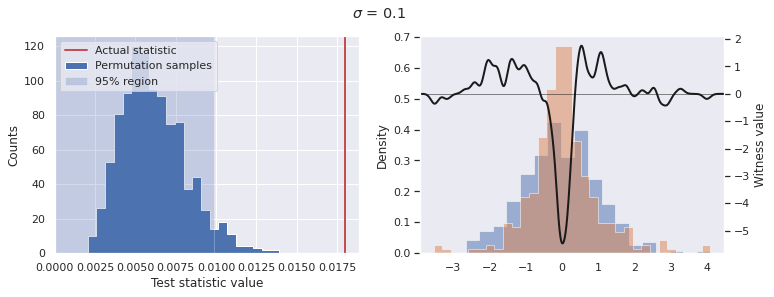

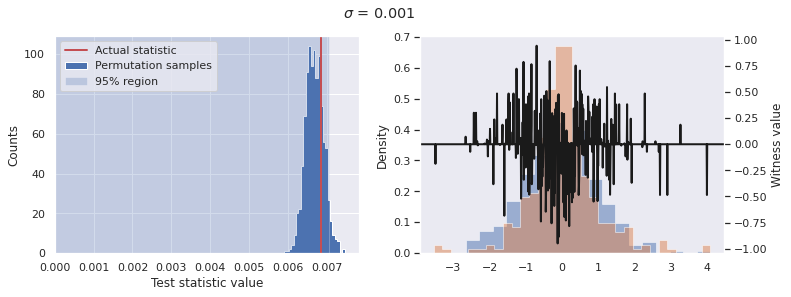

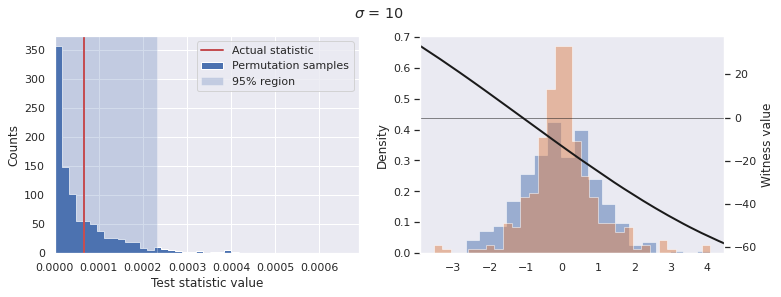

In [33]:
for sig in [.1, .001, 10]:
    K = RBFKernel(X, Y, sigma=sig)
    fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
    plot_permutation_samples(*mmd2_permutations(K), ax=a1, from_zero=True)
    plot_mmd_witness_1d(K, ax=a2)
    fig.suptitle(f"$\sigma$ = {sig}")

Make sure you intuitively understand what happened here (especially the witness plots).

Anyway, remember the median heuristic rule from before? That also works for two-sample testing, for many datasets. Let's try it here:

0.8674025535583496

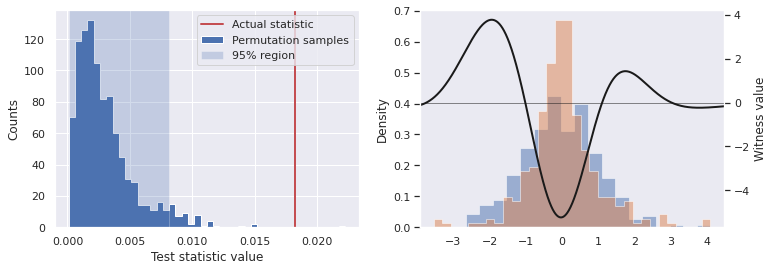

In [34]:
def median_distance(Z):
    # TODO: compute the median distance among the stacked samples Z
    # If you want to be fancy, add options to optionally subset if Z is big.
    median_dist = torch.median(torch.pdist(Z))  # SOLUTION
    return median_dist

med = median_distance(torch.cat([X, Y], 0))
K = RBFKernel(X, Y, sigma=med)

fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
plot_permutation_samples(*mmd2_permutations(K), ax=a1, one_sided=True)
plot_mmd_witness_1d(K, ax=a2)

med.item()

So the default 1 wasn't too far off, actually. The median heuristic worked great!

But it doesn't always.

### A dataset where the median heuristic doesn't work

In [35]:
# SOLUTION CELL
from sklearn.utils import check_random_state

def sample_blobs(n=500, ratio=0.01, rows=10, cols=10, sep=10, rs=None):
    rs = check_random_state(rs)
    # ratio is eigenvalue ratio
    correlation = (ratio - 1) / (ratio + 1)

    # generate within-blob variation
    mu = np.zeros(2)
    sigma = np.eye(2)
    X = rs.multivariate_normal(mu, sigma, size=n)

    corr_sigma = np.array([[1, correlation], [correlation, 1]])
    Y = rs.multivariate_normal(mu, corr_sigma, size=n)

    # assign to blobs
    X[:, 0] += rs.randint(rows, size=n) * sep
    X[:, 1] += rs.randint(cols, size=n) * sep
    Y[:, 0] += rs.randint(rows, size=n) * sep
    Y[:, 1] += rs.randint(cols, size=n) * sep

    return X.astype(np.float32), Y.astype(np.float32)

X, Y = sample_blobs(rs=0)
np.savez('data/blobs.npz', X=X, Y=Y)

X, Y = sample_blobs(rs=1)
np.savez('data/blobs2.npz', X=X, Y=Y)

X, Y = sample_blobs(rs=2, rows=1, cols=1)
np.savez('data/blobs_single.npz', X=X, Y=Y)

Text(0.5, 1.0, 'One blob (zoomed in)')

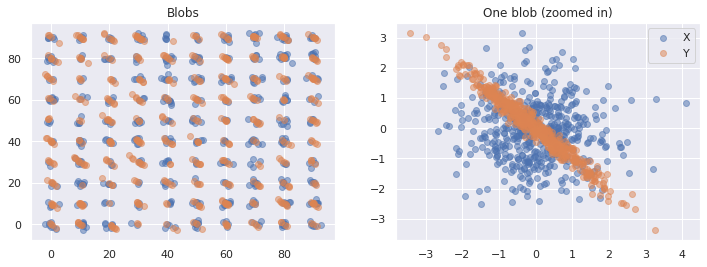

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

with np.load('data/blobs.npz') as d:
    X, Y = as_tensors(d['X'], d['Y'])
ax1.scatter(*X.t(), alpha=.5, label='X')
ax1.scatter(*Y.t(), alpha=.5, label='Y')
# ax1.legend()
ax1.set_title("Blobs")

with np.load('data/blobs_single.npz') as d:
    ax2.scatter(*d['X'].T, alpha=0.5, label='X')
    ax2.scatter(*d['Y'].T, alpha=0.5, label='Y')
ax2.legend()
ax2.set_title("One blob (zoomed in)")

These two distributions are clearly very different. But the scale at which they're different is much smaller than the median distance, which looks mostly at global structure.

51.60186767578125

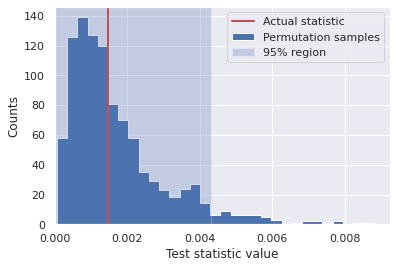

In [37]:
med = median_distance(torch.cat([X, Y], 0))
K = RBFKernel(X, Y, sigma=med)

plot_permutation_samples(*mmd2_permutations(K), from_zero=True)
med.item()

As a machine learner (and maybe forgetting about the end of the ridge regression notebook from earlier), your first instinct might be to try a bunch of different values and see which one works best.

One question is what "best" means. Well, we can try doing cross-validation and seeing which kernel choice rejects the null most often.

Note that we need to do this kernel fitting on *separate* data than conducting our final test. Otherwise we'd overfit, and be too likely to reject the null by post-hoc picking one that was big just due to chance. In real life, if `X` and `Y` were all we had, we'd have to split them up (and guess at how much to split them by...) into a "training" and a "testing" set.

**Quick thought exercise:** What are the tradeoffs when picking a bigger training set versus a bigger testing set? When would one be a better choice? Can you try multiple values and see?

**Answer:** If the kernel parameter is relatively unimportant, or easy to pick, then a bigger testing set will give you more of a chance to identify the difference in the data. But a bigger training set will give you more ability to pick the best kernel. Unfortunately, you can only try one split (unless you correct for multiple testing). <!-- SOLUTION -->

Because I'm generous, I'm going to provide you with another set of samples to learn a kernel on. Happy birthday!

In [38]:
with np.load('data/blobs2.npz') as d:
    X_train, Y_train = as_tensors(d['X'], d['Y'])

**Exercise:** implement cross-validation or a similar scheme to estimate kernel power. [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) has some useful helpers if you want.

You'll need to:
- For each $\sigma$ in a list of candidates:
  - Split `X_train`, `Y_train` into subsets somehow (cross-validation or similar).
  - For each split:
    - Compute the $p$-value of a test based on the return value from `mmd2_permutations`.
      (You might want to pass `progress=False` and only use an outer progress bar, for cleanliness.)
    - Check whether the test rejected the null.
  - Save the portion of times it rejected the null.
- Compare (plot!) the power of each $\sigma$.
- Choose the best one, and use it to test on `X` and `Y`.

This seems to give us an idea of which kernel parameter is better. Unfortunately, this approach is quite costly and noisy. In reality, we would also want to use more folds, repeat the cross-validation, and try out more kernel parameters (play with it and you will see). It's also tough to differentiate, so scaling to more complex kernel classes seems quite challenging.

We could try one of the faster approximations for the null distribution mentioned above, for example the moment matching Gamma approach. This would speed up the procedure, but, the Gamma approximation has its limits in how accurate it is, especially for extreme values of the kernel.

Instead, we'll do something better.

### Proxy criterion for kernel power

It turns out that under the alternative $\PP \ne \QQ$,
$\MMDhat_U^2$ is asymptotically normal,
$$
\frac{\MMDhat_U^2(X, Y) - \MMD^2(\PP, \QQ)}{\sqrt{\Var_{X' \sim \PP^m, Y' \sim \QQ^m}\left[ \MMDhat_U^2(X', Y') \right]}}
\stackrel{D}{\to}
\mathcal N(0, 1)
.$$
Call that thing in the denominator,
which is the variance of $\MMDhat_U^2$ given samples of size $m$ from $\PP$ and $\QQ$,
$V_m(\PP, \QQ)$.

Under the null hypothesis $\PP = \QQ$,
we have that $m \MMDhat_U^2(X, Y)$ converges to some gross distribution (an infinite mixture of chi-squares).
Let $c_\alpha$ be the $(1-\alpha)$th quantile of that distribution,
the rejection threshold;
we don't know that exactly,
but we can estimate it with permutation testing as $\hat c_\alpha$.
In this framework, note that $c_\alpha$ depends on $\PP$ and $\QQ$ (and the kernel in the MMD)
but it *doesn't* depend on $m$,
and in the usual setting we have
$\hat c_\alpha \to c_\alpha$.

So, the power of our test – the probability of rejecting when $\PP \ne \QQ$ – is just

\begin{align}
     \Pr\left( m \MMDhat_U^2(X, Y) > \hat c_\alpha \right)
  &= \Pr\left(
       \frac{\MMDhat_U^2(X, Y) - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
     > \frac{\hat c_\alpha / m - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
   \right)
\\&\to 1 - \Phi\left(
        \frac{c_\alpha / m - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
    \right)
\\&= \Phi\left(
      \frac{\MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
    - \frac{c_\alpha}{m \sqrt{V_m(\PP, \QQ)}}
    \right)
\end{align}

We can then maximize the power of the test by maximizing the thing inside the parentheses.

Now, it turns out that for a fixed kernel, $V_m$ is $\mathcal{O}(1 / m)$, and $\MMD^2$ and $c_\alpha$ are constants. So the first term is $\mathcal{O}\left(\sqrt{m}\right)$ and the second is $\mathcal{O}\left(1 / \sqrt{m}\right)$ – which means we should be able to just ignore the second term when $m$ is reasonably large.

That means we need to choose $k$ to maximize $\MMD^2(\PP, \QQ) / \sqrt{V_m(\PP, \QQ)}$. We know how to estimate $\MMD^2$. Turns out you can also estimate $V_m$ in the same quadratic time: see [this note](https://arxiv.org/abs/1906.02104).

The note is 12 pages of dense algebra, so...I'll be here when you're done.

(Don't actually read it.)

**Bonus points:** Find a mistake in the algebra in the note. I checked it three times, but I wouldn't be at all surprised if there are still mistakes!

**Big bonus points:** Figure out a way to simplify the derivation. Seriously, huge bonus points.

Anyway, even the _expression_ for the estimator is too disgusting to write here. But I implemented it for you, in [`ds3_support.mmd2_u_stat_variance`](ds3_support/mmd.py).

In [39]:
from ds3_support import mmd2_u_stat_variance

There, I've done the hard part for you. (Also, PyTorch is doing the really hard part, which is differentiating the terrible expression.)

**Exercise:** Compare a fixed set of kernels, the different bandwidths on the blobs data, using this criterion. Does it give you the same choice as cross-validation? How many thousands of times faster is it?

This is an unbiased estimator, so it might be negative, or zero! Make sure you don't divide by zero.

**Optional:** We know how to estimate $c_\alpha$ – with permutation testing – so we could optimize the more-complete criterion, too. Does that give you different answers? What about if $m$ is fairly small?

### Gradient descent to optimize the power criterion

You know what the deal is by now:

**Exercise:** Instead of doing a grid search, optimize $\lambda$ with gradient descent.

Does it always go to the same place, or can you get stuck in local minima?

**Optional:** If you implemented a more efficient `mmd2_permutations`, and were a little careful about how you implemented it, you might even be able to differentiate your threshold estimate $\hat c_\alpha$. How does that compare?

### GAN criticism with an ARD kernel

You may have heard of Generative Adversarial Networks, GANs.
Assume someone came to you with a new GAN, which generates some realistic looking images, which they say are indistinguishable from the images used to train the GAN.

Actually, let's assume that person [said](https://arxiv.org/abs/1606.03498):
> On MTurk, annotators were able to distinguish
samples in 52.4% of cases (2000 votes total), where 50% would be obtained by random
guessing. Similarly, researchers in our institution were not able to find any artifacts that would allow
them to distinguish samples.

Let's see what the kernel MMD thinks about this.
We will use a slightly different kernel than before: an ARD ("automatic relevance determination") kernel.
You can think of this kernel as scaling each of the $D$ input dimensions by a different parameter, and then uses a standard Gaussian kernel (unit bandwidth) on top of that.
$$ k(x,y) = \exp\left(-\frac12 \sum_{d=1}^D \left( s_d x_d - s_d y_d \right)^2\right).$$

In [40]:
class ARDKernel(LazyKernel):
    def __init__(self, *parts, scales=1):
        super().__init__(*parts)
        assert len(self.X.shape) == 2
        d = self.X.shape[1]
        
        scales, = self.as_tensors(scales)
        if scales.shape == ():
            scales = scales.repeat(d)
        else:
            assert scales.shape == (d,)

        self.scales = scales
        self.const_diagonal = 1  # Says that k(x, x) = 1 for any x
    
    # TODO: implement _compute (maybe with _precompute)
    def _precompute(self, A):                      # SOLUTION
        s = A * self.scales[None, :]               # SOLUTION
        return [s, torch.einsum("id,id->i", s, s)] # SOLUTION
    
    def _compute(self, A, sc_A, sc_A_sqnorms, B, sc_B, sc_B_sqnorms):  # SOLUTION
        D2 = (sc_A_sqnorms[:, None] + sc_B_sqnorms[None, :]            # SOLUTION
              - 2 * (sc_A @ sc_B.t()))                                 # SOLUTION
        return torch.exp(-0.5 * D2)                                    # SOLUTION

In [41]:
# Check that ARDKernel at least agrees with RBFKernel in the special case:
Xtmp = torch.randn(3, 4)
sigma = torch.exp(torch.randn(()))
(ARDKernel(Xtmp, scales=1/sigma).XX
 - RBFKernel(Xtmp, sigma=sigma).XX).abs().max()

tensor(5.9605e-08)

In [42]:
with np.load('data/gan-samples.npz') as d:
    X, Y = [t.reshape(-1, 784).float() for t in as_tensors(d['X'], d['Y'])]

'X (true MNIST) samples:'

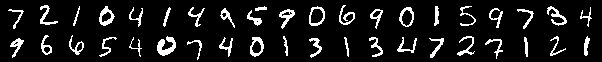

'Y (GAN) samples:'

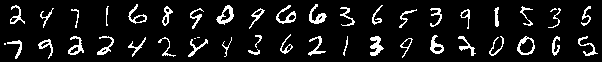

In [43]:
display("X (true MNIST) samples:")
display(pil_grid(X[:40].reshape(-1, 1, 28, 28), nrow=20))
display("Y (GAN) samples:")
display(pil_grid(Y[:40].reshape(-1, 1, 28, 28), nrow=20))

**Exercise:** How does a median-heuristic RBF kernel perform on this problem?

**Exercise:** Split the data, and optimize an ARD kernel with gradient descent to compare thesem; then run the test on the other half of the data. Does it do better?

Can you interpret the ARD weights `K.scales`?

We can't do the 1d witness function plot, but can you think of a different way to figure out "where" the distributions are different?

## Independence testing

So far, we've been asking whether $\PP = \QQ$ for two different distributions. Sometimes we'd rather do a related problem, *independence testing*. That is, we have paired data $\{ (X_i, Y_i) \}_{i=1}^n \sim \PP_{XY}^n$, and we want to know whether $X$ and $Y$ are independent or not.

By definition, this is the same thing as asking whether $\PP_{XY} = \PP_X \times \PP_Y$, the product of the marginal distributions. But we know how to do that: if we use a characteristic kernel on the joint space, they're independent if and only if $\MMD(\PP_{XY}, \PP_{X} \times \PP_Y) = 0$.
The quantity $\MMD(\PP_{XY}, \PP_{X} \times \PP_Y)^2$  is also called the HSIC ("Hilbert-Schmidt Independence Criterion"). 

Usually we choose a kernel $k$ for $X$ and a kernel $\ell$ for $L$, and use the _product kernel_ on the joint space:
$$
  (k \times \ell)( (x, y), (x', y') )
  = k(x, x') \ell(y, y')
.$$
It turns out you can estimate it like this:
$$
\frac{1}{n^2} \Tr\left( H K H L \right)
,$$
where $K$ is the kernel matrix on the $X$ samples,
$L$ is the kernel matrix on the $L$ samples,
and $H = I - \frac1n \mathbf{1} \mathbf{1}^T$ is the _centering matrix_.

**Exercise:** Implement the HSIC estimator. You can do it literally as written here, with an H matrix and taking matrix products and so on. Or, if you want a more efficient implementation – $\mathcal{O}(n^2)$ instead of $\mathcal{O}(n^3)$ – you can notice a few things:

- If you expand out what $H K H$ does, you can easily implement it in quadratic time.
- $\Tr(A B) = \sum_i ( A B )_{ii} = \sum_i \sum_j A_{ij} B_{ji}$, which you can easily implement in quadratic time.

In [44]:
def _as_kernel_matrices(K, L):
    if isinstance(K, LazyKernel):
        K = K.XX
    if isinstance(L, LazyKernel):
        L = L.XX
    K, L = as_tensors(K, L)
    assert len(K.shape) == len(L.shape) == 2
    assert K.shape[0] == K.shape[1] == L.shape[0] == L.shape[1]
    return K, L

In [45]:
def hsic_est(K, L):
    K, L = _as_kernel_matrices(K, L)
    
    # TODO: implement the HSIC estimator
    return hsic

To run a test, we'll also need to do permutations. Note that permutations are slightly different from before: we'll need to permute $K$ and $L$ *separately*, so that $\{(x_i, y_i)\}$ becomes $\{(x_i, y_j)\}$, and any possible dependence between them is broken.

Here's some framework for computing permuations for the HSIC estimator. If you want to do it a faster way, go ahead.

In [46]:
def hsic_permutations(K, L, num_permutations=1000, progress=True):
    K, L = _as_kernel_matrices(K, L)

    est = hsic_est(K, L)

    range_ = range(num_permutations)
    if progress:
        range_ = tqdm(range_)
    
    stats = []
    for i in range_:
        pass # TODO: permute the entries of K and L and call hsic_est
    
    return two_sample_permutation_test(
        mmd2_with_K, K.X, K.Y,
        num_permutations=num_permutations, progress=progress)

Let's try it on some simple data.

In [47]:
# SOLUTION CELL
def sample_hsic(n, angle, sigma=0.2, offset=1):
    n4 = int(n/4)
    N = np.random.randn(n4, 2)*sigma
    S = np.random.randn(n4, 2)*sigma
    E = np.random.randn(n4, 2)*sigma
    W = np.random.randn(n4, 2)*sigma
    
    N[:,1] += offset
    S[:,1] -= offset
    W[:,0] -= offset
    E[:,0] += offset
    
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    A = R.dot(np.vstack((N,S,W,E)).T).T
    
    A = A.astype(np.float32)
    return A[:, 0], A[:, 1]

N = 200
np.random.seed(0)
X, Y = sample_hsic(n=N, angle=np.pi/12)
np.savez("data/hsic.npz", X=X, Y=Y)

In [48]:
with np.load('data/hsic.npz') as d:
    X, Y = as_tensors(d['X'], d['Y'])

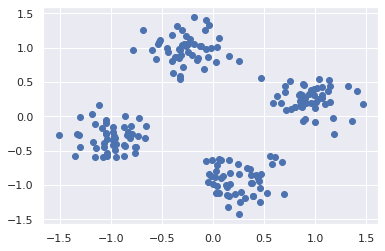

In [49]:
fig, ax = plt.subplots()
ax.scatter(X, Y)

Clearly, there is some very simple dependence going on.
The first thing a statistician would do is of course to check for correlation.

In [50]:
print("Correlation between X and Y:", np.corrcoef(X, Y)[0,1])

Correlation between X and Y: 0.023122960723689145


The correlation is very low.
A kernel test for independence is more powerful, even with a bandwidth parameter chosen by the median heuristic.

**Exercise:** Implement and visualize this test.

<!-- SOLUTION CELL -->
## European parliament documents translations and string kernels

We will now do a slightly more elaborate test that involves some very mild NLP.
More precisely we will analyze dependence between documents.
We will use transcripts of the Canadian parliament's house debates, downloaded from [here](https://www.isi.edu/natural-language/download/hansard/).
Those consist of pairs of French and English transcripts. Here's the end of two corresponding documents:

> d until tomorrow at 2 p.m., pursuant to Standing Order 24(1).  
> (The House adjourned at 6.41 p.m.) 

> main, à 10 heures, conformément à l'article 24(1) du Règlement.  
> (La séance est levée à 18 h 20.) 

Our question here is whether we can detect this supposedly strong dependence structure using the kernel HSIC.
Note that this approach does not rely on attempting to translate the documents, but rather on comparing within-document structure. 
HSIC compares the self-similarity within the English documents with self-similarity of the French ones.

We're going to construct a string kernel, a  "bag of words" kernel between documents $s$ and $t$,

$$
k(s,t) = \frac{1}{|\mathcal{W}|} \phi(s)^\top \phi(t)
$$

where $\mathcal{W}$ consists of all words on all considered documents, and each element of $\phi(x)\in\mathbb{N}^{|\mathcal{W}|}$ contains the number of times that a particular word $w\in\mathcal{W}$ appears in $x$.

Naturally, the kernel value will be larger, if a word appears in both documents many times.

Efficient implementations of string kernels are rare (Shogun has many!), and often based on low-level dynamic programming concepts.
Instead, we will here explicitly embed the documents into a feature space and compute (gram) matrix of inner products manually. 
Note that most string kernel implementations are much more efficient in computing the kernel since they don't do the feature space mapping explicitly.

In [51]:
# stopwords, from nltk.corpus.stopwords
with open('data/stopwords-english.txt') as f:
    en_stop = {x.strip() for x in f}
with open('data/stopwords-french.txt') as f:
    fr_stop = {x.strip() for x in f}

To make things faster, we're going to use the "hashing trick" to featurize this documents as bags of words – that is, each document is a count of how many times each unique word showed up. Rather than keeping track of a vocabulary, we use a hash function to map each word to a (probably) unique index.

In [52]:
import re
import tarfile
from scipy import sparse

en_feats = {}
fr_feats = {}

from sklearn.feature_extraction.text import HashingVectorizer
en_vec = HashingVectorizer(
    analyzer="word", decode_error='replace', stop_words=en_stop,
)
fr_vec = HashingVectorizer(
    analyzer="word", decode_error='replace', stop_words=fr_stop,
)

with tarfile.open('data/transcripts.tar.bz2') as tar:
    for info in tqdm(tar):
        fname = info.name
        is_french = fname.endswith("f")
        is_english = fname.endswith("e")
        if not (is_english or is_french):
            continue
        
        with tar.extractfile(info) as f:
            if is_english:
                en_feats[fname] = en_vec.transform([f.read()])
            else:
                fr_feats[fname] = fr_vec.transform([f.read()])
#             (en_vec if is_en)
#             (X if is_english else Y).append(content)

assert len(en_feats) == len(fr_feats)
names = {k[:-1] for k in en_feats}

X = sparse.vstack([en_feats[k + 'e'] for k in names])
Y = sparse.vstack([fr_feats[k + 'f'] for k in names])

|          | 0/? [00:00<?, ?it/s]

Our features are enormous (and enormously sparse) matrices.

In [53]:
X

<313x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 1388461 stored elements in Compressed Sparse Row format>

Now, our PyTorch infrastructure isn't going to like these matrices with 1 million columns. We're only going to use a linear kernel, though, so we can just compute the kernel ourselves. (You can convert from these sparse matrix classes to numpy arrays with `toarray()`, but do it *after* computing the kernel matrix to avoid trying to allocate an enormous dense array:

In [54]:
# TODO: compute kernels
K_XX = (
    # ...
    X @ X.T   # SOLUTION
).toarray().astype(np.float32)
K_YY = (
    # ...
    Y @ Y.T   # SOLUTION
).toarray().astype(np.float32)

In [55]:
# TODO: run the HSIC test with these kernels

We can clearly see that the English and French documents are not independent.